### _Activity feature extractor using custom model_
Author : @leopauly | cnlp@leeds.ac.uk <br>
Description : Custom build network for extracting action features from a video <br>
Status : Incomplete

In [1]:
## Imports
import numpy as np
import cv2
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, MaxPooling2D, Input, Concatenate,MaxPooling3D, Reshape
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
import numpy as np
import pylab as plt
import keras
import keras.backend as K

## Custom scripts
import lscript as lsp
import dataset as dset

Using TensorFlow backend.


In [2]:
## Defining variables
time_step=50 # Number of frames to be skipped
imagefolderpath= ('/nobackup/leopauly/KTH_new/') # Folder pathe where the video sequences are stored
print(os.path.isdir(imagefolderpath)) # Checking if directory of video dataset exists
LOG_DIR='./logdir'
custom_global_step=0
hidden_num = 24 # Number of neurons in hidden layer of LSTM
nb_classes=3
lr_rate=.0005
batch_size = 5
nb_seq_train=360
no_of_batches = int(nb_seq_train / batch_size)
epoch = 10
height=150
width=300
channel=1
lstm_h_units=10
cluster_length=5
num_clusters=3

True


#### Loading and displaying data

label:2.0
Video_seq shape: (5, 50, 150, 300) Label shape (5,)


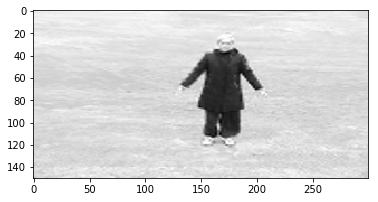

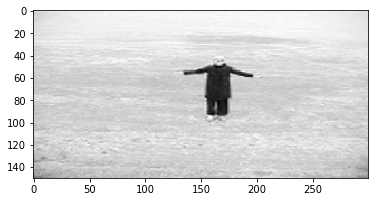

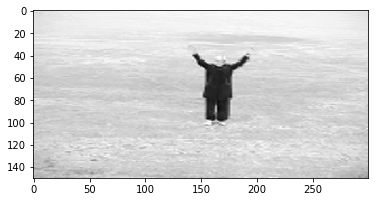

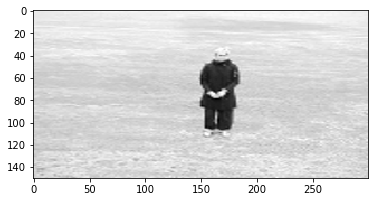

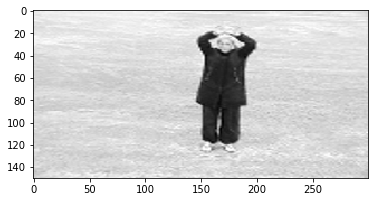

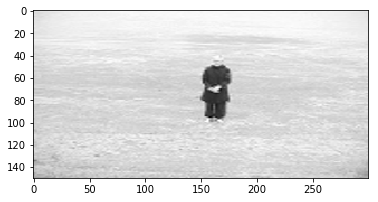

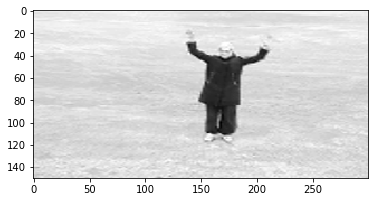

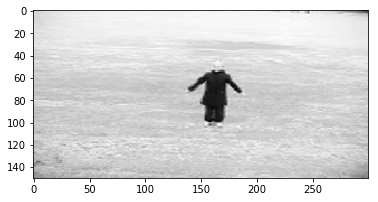

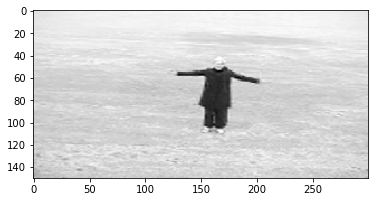

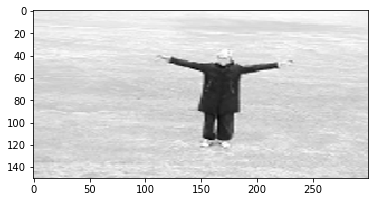

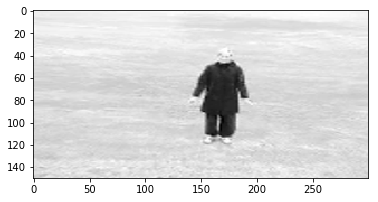

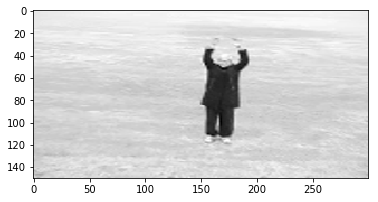

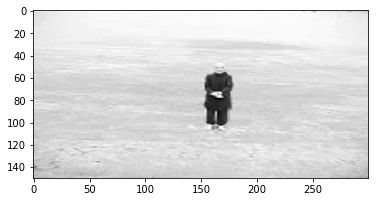

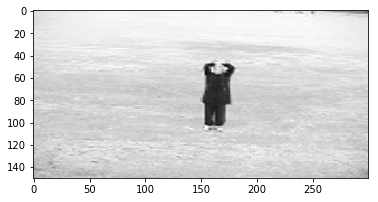

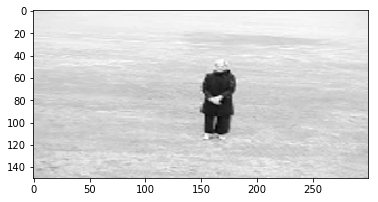

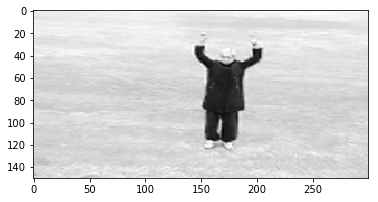

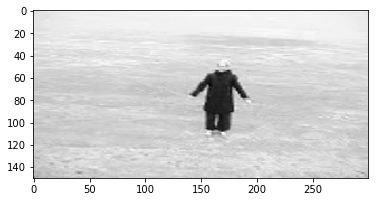

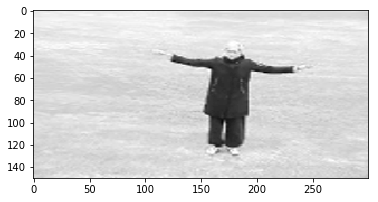

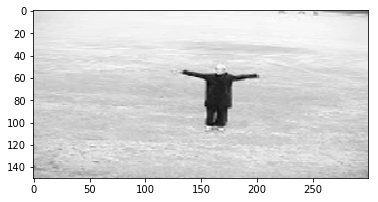

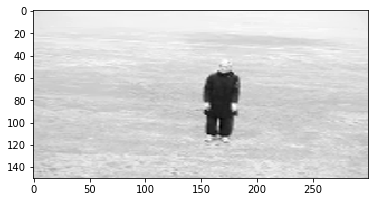

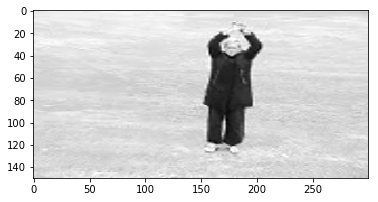

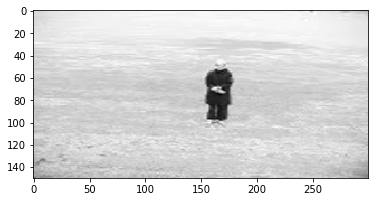

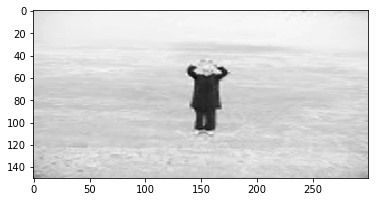

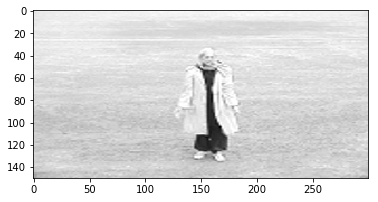

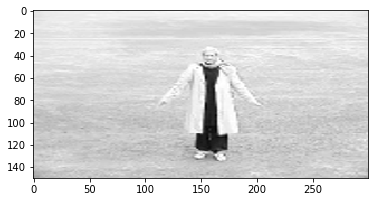

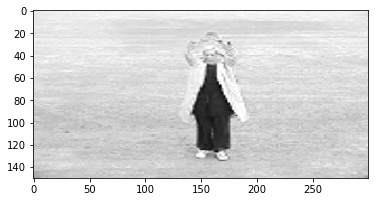

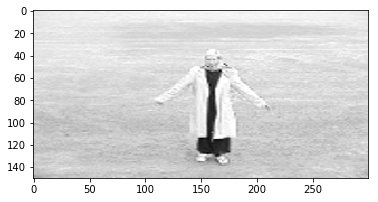

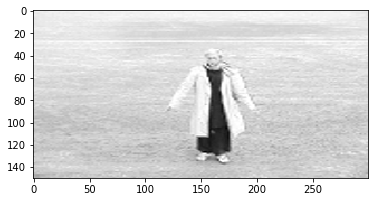

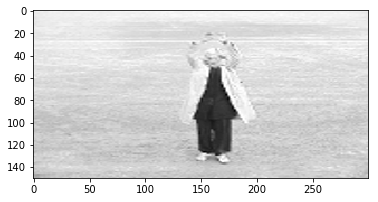

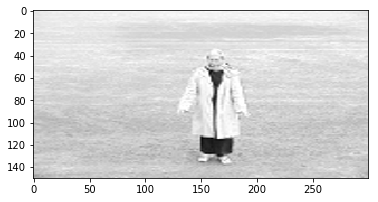

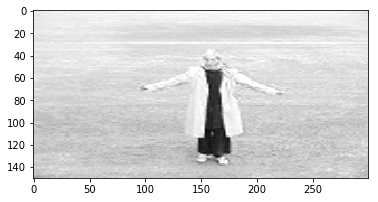

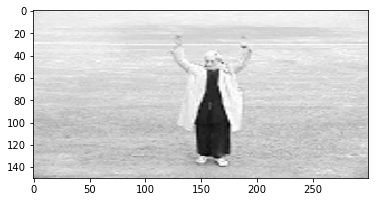

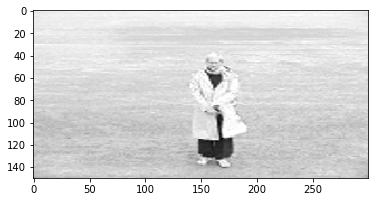

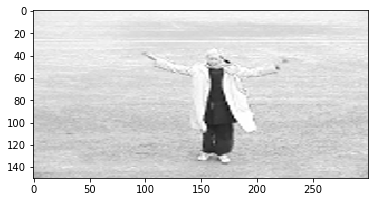

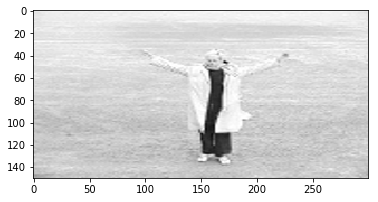

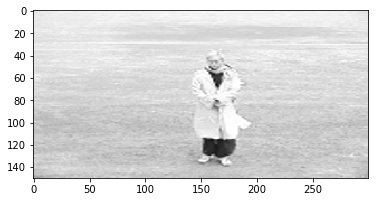

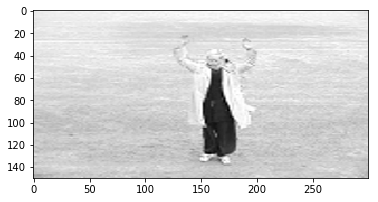

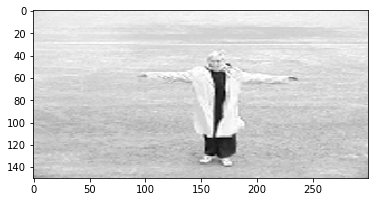

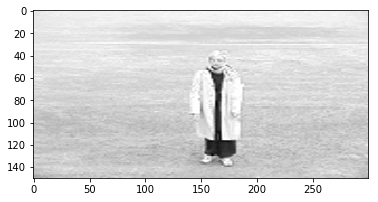

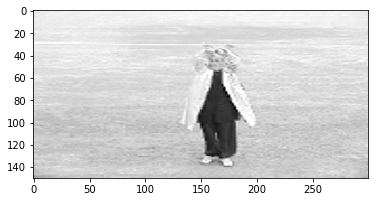

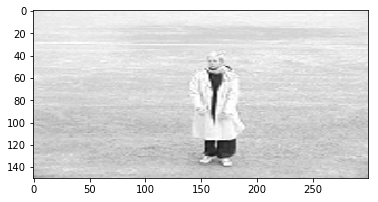

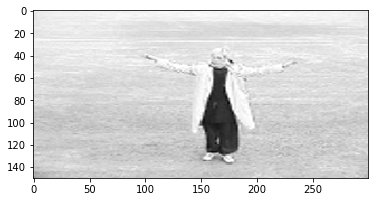

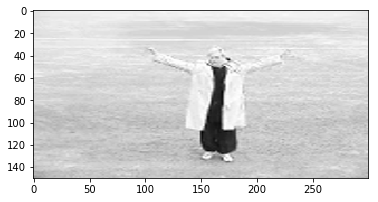

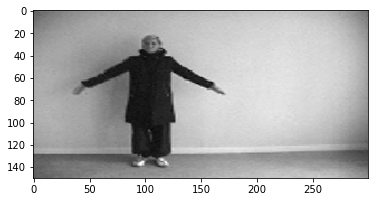

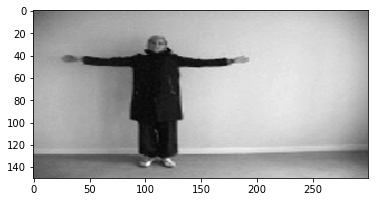

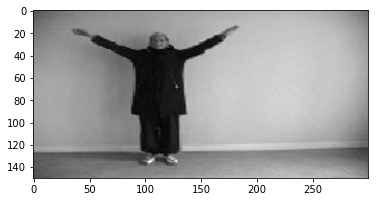

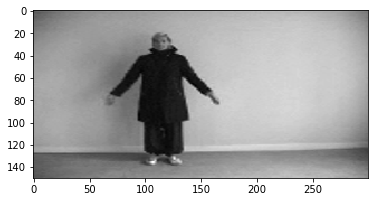

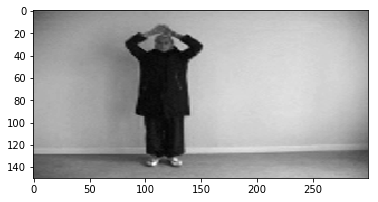

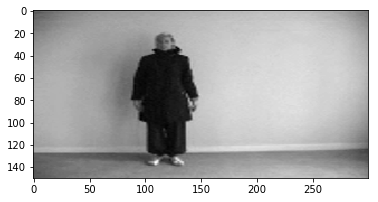

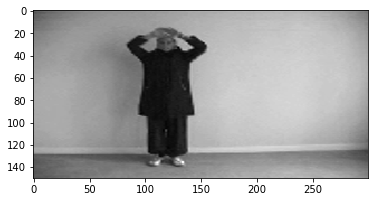

In [3]:
# TODO: Make display like an animation
x,y=dset.batch_gen_train(nb_classes,batch_size,time_step,height,width,channel,imagefolderpath,gray=True)
item_num=1
lsp.view_video_seq(x,y,time_step,item_num)

#### Defining model

In [4]:
## Defining placeholders in tf
data_1 = tf.placeholder(tf.float32, [None, cluster_length, height, width, channel]) #step_size=No: of frames in video sequence
data_2 = tf.placeholder(tf.float32, [None, cluster_length, height, width, channel])
data_3 = tf.placeholder(tf.float32, [None, cluster_length, height, width, channel])
target = tf.placeholder(tf.float32, [None, nb_classes])

In [5]:
## Suggested Network structure: Conv3D followed by LSTM

def cnn_modeling():
    input_cnn = Input(shape=(cluster_length, height, width, channel))
    
    cnn_1=Conv3D(filters=64, kernel_size=(3,3,3),padding='same',activation='relu')(input_cnn)
    pool_1=MaxPooling3D(pool_size=(1, 2, 2),strides=(1, 2, 2),padding='valid')(cnn_1)
    
    cnn_2=Conv3D(filters=128, kernel_size=(3,3,3),padding='same',activation='relu')(pool_1)
    pool_2=MaxPooling3D(pool_size=(2, 2, 2),strides=(2, 2, 2),padding='valid')(cnn_2)
    
    cnn_3a=Conv3D(filters=256, kernel_size=(3,3,3),padding='same',activation='relu')(pool_2)
    cnn_3b=Conv3D(filters=256, kernel_size=(3,3,3),padding='same',activation='relu')(cnn_3a)
    pool_3=MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2),padding='valid')(cnn_3b)
    
    #cnn_4a=Conv3D(filters=512, kernel_size=(3,3,3),padding='same',activation='relu')(pool_3)
    #cnn_4b=Conv3D(filters=512, kernel_size=(3,3,3),padding='same',activation='relu')(cnn_4a)
    #pool_4=MaxPooling3D(pool_size=(2, 2, 2),strides=(2, 2, 2),padding='valid')(cnn_4b)
    
    #cnn_5a=Conv3D(filters=64, kernel_size=(3,3,0),padding='same',activation='relu')(pool_4)
    #cnn_5b=Conv3D(filters=64, kernel_size=(3,3,0),padding='same',activation='relu')(cnn_5a)
    #ßpool_5=MaxPooling3D(pool_size=(time_step, 8, 8),strides=(2, 4, 4),padding='valid')(cnn_5b)
    
    #flat= Flatten()(pool_3)
    flat=Reshape([1,-1])(pool_3)
    
    # FC layers group
    fc_1=Dense(4096, activation='relu')(flat)
    drop_1=Dropout(.5, name='do1')(fc_1)
    fc_2=Dense(4096, activation='relu')(drop_1)
    drop_2=Dropout(.5, name='do2')(fc_2)
    fc_2=Dense(487, name='fc8')(drop_2)
    
    model_cnn=Model(input_cnn,fc_2)
    print(model_cnn.summary())
    return model_cnn

input_1 = Input(shape=(cluster_length, height, width, channel))
input_2 = Input(shape=(cluster_length, height, width, channel))
input_3 = Input(shape=(cluster_length, height, width, channel))

model_cnn=cnn_modeling()
layer1_1=model_cnn(inputs=input_1)
layer1_2=model_cnn(inputs=input_2)
layer1_3=model_cnn(inputs=input_3)

concat= keras.layers.concatenate([layer1_1, layer1_2,layer1_3],1)
layer2=keras.layers.LSTM(lstm_h_units,return_sequences=True)(concat)
layer3= Reshape([num_clusters*lstm_h_units])(layer2)
model=Model([input_1,input_2,input_3],layer2)
logit_out=model([data_1,data_2,data_3])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 5, 150, 300, 1)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 5, 150, 300, 64)   1792      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 5, 75, 150, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 5, 75, 150, 128)   221312    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 2, 37, 75, 128)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 2, 37, 75, 256)    884992    
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 2, 37, 75, 256)    1769728   
__________

In [6]:
predictions= tf.nn.softmax(logit_out)
cross_entropy=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=target,logits=logit_out))
optimizer = tf.train.AdamOptimizer(lr_rate)
minimize = optimizer.minimize(cross_entropy)
mistakes = tf.not_equal(tf.argmax(target, 1), tf.argmax(predictions, 1))
error = tf.reduce_mean(tf.cast(mistakes, tf.float32))

## Defining variables for writing summary
#tf.summary.histogram("predictions",predictions )
tf.summary.scalar("cross_entropy",cross_entropy )
tf.summary.scalar("test_error",error )
summary_op = tf.summary.merge_all()

#### Training model

In [7]:
init_op = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init_op)

saver = tf.train.Saver()
train_writer = tf.summary.FileWriter('./logdir', sess.graph)

for i in range(epoch):
    ptr = 0
    for iteration in range(no_of_batches):
        #x=dset.batch_gen(0+(batch_size*iteration),batch_size+(batch_size*iteration),batch_size,time_step,height,width,channel,imagefolderpath,gray=True)
        x,y=dset.batch_gen_train(nb_classes,batch_size,cluster_length,height,width,channel,imagefolderpath,gray=True)
        x =x.reshape(x.shape[0],x.shape[1],height,width,channel)
        y_onehot = lsp.one_hot(y,nb_classes)
        #print(x.shape,y.shape)
        
        summ_string,_=sess.run([summary_op,minimize],{data_1: x,data_2:x,data_3:x, target: y_onehot})
        train_writer.add_summary(summ_string,custom_global_step+1) # Writing summary to disc
        custom_global_step+=1
        
        print('Iteration {}'.format(iteration))
    print ('Epoch {}'.format(str(i)))

saver.save(sess, os.path.join(LOG_DIR, "activity_model.ckpt"))

ResourceExhaustedError: OOM when allocating tensor with shape[170496,4096]
	 [[Node: dense_1/kernel/Adam_1/Assign = Assign[T=DT_FLOAT, _class=["loc:@dense_1/kernel"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](dense_1/kernel/Adam_1, dense_1/kernel/Adam_1/Initializer/Const)]]

Caused by op 'dense_1/kernel/Adam_1/Assign', defined at:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-be6524a8c9a8>", line 4, in <module>
    minimize = optimizer.minimize(cross_entropy)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 325, in minimize
    name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 446, in apply_gradients
    self._create_slots([_get_variable_for(v) for v in var_list])
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/training/adam.py", line 123, in _create_slots
    self._zeros_slot(v, "v", self._name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 766, in _zeros_slot
    named_slots[_var_key(var)] = slot_creator.create_zeros_slot(var, op_name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 174, in create_zeros_slot
    colocate_with_primary=colocate_with_primary)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 146, in create_slot_with_initializer
    dtype)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 66, in _create_slot_var
    validate_shape=validate_shape)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1049, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 948, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 356, in get_variable
    validate_shape=validate_shape, use_resource=use_resource)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 341, in _true_getter
    use_resource=use_resource)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 714, in _get_single_variable
    validate_shape=validate_shape)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 197, in __init__
    expected_shape=expected_shape)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 306, in _init_from_args
    validate_shape=validate_shape).op
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 270, in assign
    validate_shape=validate_shape)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 47, in assign
    use_locking=use_locking, name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[170496,4096]
	 [[Node: dense_1/kernel/Adam_1/Assign = Assign[T=DT_FLOAT, _class=["loc:@dense_1/kernel"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](dense_1/kernel/Adam_1, dense_1/kernel/Adam_1/Initializer/Const)]]


#### Evaluating performance

In [ ]:
test_batch_size=10
x,y=dset.batch_gen_train(nb_classes,test_batch_size,time_step,height,width,channel,imagefolderpath,gray=True)
x =x.reshape(x.shape[0],x.shape[1],height,width,channel)
y_onehot = lsp.one_hot(y,nb_classes)

error_rate= sess.run(error,feed_dict={data_1: x,data_2:x,data_3:x, target: y_onehot})
print('error {} %'.format(error_rate*100))

#### Visualising layers

In [ ]:
x,y=dset.batch_gen_train(nb_classes,batch_size,time_step,height,width,channel,imagefolderpath,gray=True)
x =x.reshape(x.shape[0],x.shape[1],height,width,channel)
y_onehot = lsp.one_hot(y,nb_classes)

img=x[12]
print(img.shape)
img=img.reshape(1,img.shape[0],height,width,channel)
print(img.shape)
y_=np.zeros([1,nb_classes])
units = sess.run(inter_out,feed_dict={data:img, target:y_})
print(units.shape)
units=units.reshape(units.shape[1],units.shape[2])
print(units.shape)
plt.imshow(units)
plt.gray()
plt.savefig('./results/result6.png')
plt.show()

#### Restoring a model and then visualising layers

In [ ]:
sess=tf.InteractiveSession() 
saved_model = tf.train.import_meta_graph('./logdir/activity_model.ckpt.meta')
saved_model.restore(sess, tf.train.latest_checkpoint('./logdir'))

In [ ]:
img=x[1]
print(img.shape)
img=img.reshape(1,img.shape[0],height,width,channel)
print(img.shape)
y_=np.zeros([1,nb_classes])
units = sess.run(inter_out,feed_dict={data:img, target:y_})
print(units.shape)
units=units.reshape(units.shape[1],units.shape[2])
print(units.shape)
plt.imshow(units)
plt.gray()
plt.savefig('./results/result3.png')
plt.show()

#### Tensorboard

In [ ]:
# Checking the items in the log directory
!tensorboard --inspect --logdir='./logdir/'

# Running tensorflow
print('If on windows system go to: http://localhost:6006')
!tensorboard --logdir='./logdir/'

In [ ]:
sess.close()